In [1]:
import os
import sys
sys.path.append(os.getcwd() + '/..')
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from pybay.bert import EBertModel, EBertTokenizer
from simcse import SimCSE
from tqdm.notebook import trange, tqdm
from sklearn import metrics
from sklearn.manifold import TSNE
np.random.seed(114514)
torch.manual_seed(114514)

In [49]:
model_path = './../models/retrieval/entity_type_tuned_sota/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimCSE(model_path,device=device,tokenizer_class=EBertTokenizer,model_class=EBertModel)

04/20/2023 10:34:10 - INFO - pybay.bert.ebert_transformers.tokenization_utils -   Failed to find a tokenizer ./../models/retrieval/entity_type_tuned_sota/ in pybay registry. Trying to load a tokenizer from a local path
04/20/2023 10:34:10 - INFO - pybay.bert.ebert_transformers.modeling_utils -   Failed to find a model name ./../models/retrieval/entity_type_tuned_sota/ in pybay registry. Trying to load a model from a local path
04/20/2023 10:34:10 - INFO - pybay.bert.ebert_transformers.configuration_utils -   Failed to find a config ./../models/retrieval/entity_type_tuned_sota/ in pybay registry. Trying to load a config from a local path


In [50]:
cat_data = pd.read_csv('./../data/raw/Cat_data.csv')
mappings_data = pd.read_csv('./../data/raw/Aggregated_siblings_data.csv')
neg = mappings_data[mappings_data['Parent Label'] == 'All products']
mappings_data = mappings_data.drop(neg.index)
large_index = mappings_data[mappings_data['Cluster size'] > 60].index
small_index = mappings_data[mappings_data['Cluster size'] == 4].index[:60]
classlabels = list(cat_data['Label'])
embeddings = model.encode(classlabels)
model.build_index(classlabels)
knn = model.search(classlabels,threshold=0,top_k=int(mappings_data['Cluster size'].max()))

100%|██████████| 318/318 [00:07<00:00, 43.94it/s]


In [51]:
catid_dict = {}
idx_dict = {}
for i,row in cat_data.iterrows():
    catid_dict[row['Cat ID']]=i
    idx_dict[i]=row['Cat ID']
def idx_to_catid(x):
    return idx_dict[x]
def catid_to_idx(cid):
    return catid_dict[cid]

In [57]:
def evaluate(model,class_data,mappings_data,precomputed_knn=None,weighted=False,weight='Linear',repeat:int=10):
    if precomputed_knn:
        knn = precomputed_knn
    else:
        print("Computing k-NN:")
        k = 1+4*mappings_data['Cluster size'].max()
        classlabels = list(class_data['Label'])
        model.build_index(classlabels)
        knn = model.search(classlabels,threshold=0,top_k=int(k))
    print("Evaluating metrics:")
    cluster_ids = mappings_data['Cluster ID'].unique()
    M = len(cluster_ids)
    pltdomain = np.arange(0.1,2.1,0.1)
    hits = np.zeros([pltdomain.shape[0],M,repeat])
    with tqdm(total = repeat, position = 0, desc = 'Repetition') as outer:
        with tqdm(total = M, position = 1, leave = False, desc = 'Cluster') as inner:
            for r in range(repeat):
                inner.reset()
                for j,c in enumerate(cluster_ids):
                    cluster = mappings_data[mappings_data['Cluster ID'] == c]
                    randclass = cluster.sample(n=1)['Cat ID'].iloc[0]
                    ref_cluster_ids = mappings_data[mappings_data['Cat ID'] == randclass]['Cluster ID'].unique()
                    reference = set(mappings_data[mappings_data['Cluster ID'].isin(ref_cluster_ids)]['Cat ID'])
                    n = len(reference)
                    predictions = [idx_to_catid(entry[0]) for entry in knn[catid_to_idx(randclass)]]
                    for i,x in enumerate(pltdomain):
                        sublist = predictions[:int(np.ceil(x*n))]
                        hits[i][j][r] = len(set(sublist).intersection(reference)) / n
                    inner.update(1)
                outer.update(1)
    recall = np.mean(hits,axis=(1,2))
    err = 1.96*np.std(np.mean(hits,axis=1),axis=1)/np.sqrt(repeat)
    print(f"Hit @ N/2:{recall[4]:.4f}\nHit @ N:{recall[9]:.4f}\nHit @ 2N:{recall[19]:.4f}\n")
    fig, ax = plt.subplots()
    ax.errorbar(pltdomain, recall, yerr=err)
    plt.xlabel("Sampling ratio")
    plt.ylabel("Recall")
    plt.show()
    return hits

Evaluating metrics:


Repetition:   0%|          | 0/10 [00:00<?, ?it/s]

Cluster:   0%|          | 0/3074 [00:00<?, ?it/s]

Hit @ N/2:0.2771
Hit @ N:0.3715
Hit @ 2N:0.4531



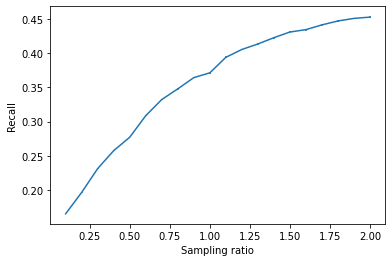

In [58]:
eval_details = evaluate(model,cat_data,mappings_data,precomputed_knn=knn)

In [102]:
randseed = np.random.choice(len(classlabels),1).item()
num_candidates = 15
knn_results = [(idx_to_catid(entry[0]),entry[1],entry[2]) for entry in knn[randseed][:num_candidates+1]]
ref_clusters = mappings_data[mappings_data['Cat ID'] == idx_to_catid(randseed)]['Cluster ID'].unique()
reference = mappings_data[mappings_data['Cluster ID'].isin(ref_clusters)]
ref_id = set(reference['Cat ID'])
predictions = pd.DataFrame([(name, sim, 'Seed' if catid == idx_to_catid(randseed) else catid in ref_id) for catid, name, sim in knn_results],columns=['Category','Similarity','In reference'])
display(predictions)
display(reference)

,Category,Similarity,In reference
0,Men's Activewear Tops,1.000000,Seed
1,Men's Vintage Casual Shirts,0.999057,False
2,Women's Equestrian Shirts & Tops,0.998972,False
3,Men's Shirts,0.998895,False
4,Baby & Toddler Tops & T-Shirts,0.998328,True
5,"Boys' Tops, Shirts & T-Shirts",0.998146,True
6,"Girls' Tops, Shirts & T-Shirts",0.997677,True
7,Women's Tops,0.997652,True
8,Youth Equestrian Shirts & Tops,0.997471,False
9,Women's Activewear Tops,0.997334,True


,Cat ID,Parent Label,Self Label,Cluster ID,Cluster size
3267,260965,Shirt,"Girls' Tops, Shirts & T-Shirts",681,21
3268,260031,Shirt,Baby & Toddler Tops & T-Shirts,681,21
3269,179982,Shirt,Fishing Shirts & Tops,681,21
3270,181138,Shirt,Men's Golf Shirts & Tops,681,21
3271,179830,Shirt,Youth Exercise Tops & Jerseys,681,21
3272,181149,Shirt,Women's Golf Shirts & Tops,681,21
3273,155199,Shirt,Unisex Kids' Tops & T-Shirts,681,21
3274,59368,Shirt,Men's Exercise Tops & Jerseys,681,21
3275,59333,Shirt,Women's Exercise Tops & Jerseys,681,21
3276,57990,Shirt,Men's Casual Button-Down Shirts,681,21


In [37]:
# embed_tsne3 = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=50).fit_transform(embeddings.numpy())
embed_tsne2 = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=50).fit_transform(embeddings.numpy())

In [38]:
large_clusters = embed_tsne2[large_index]
x = large_clusters[:,0]
y = large_clusters[:,1]
color = np.array(mappings_data['Cluster ID'][large_index])
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(x,y,s=6,c=color)
ax.set_title('Large clusters')
plt.show()

IndexError: index 20721 is out of bounds for axis 0 with size 20322

In [ ]:
small_clusters = embed_tsne2[small_index]
x = small_clusters[:,0]
y = small_clusters[:,1]
color = np.array(mappings_data['Cluster ID'][small_index])
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(x,y,s=6,c=color)
ax.set_title('Small clusters')
plt.show()

In [ ]:
# large_clusters3 = embed_tsne3[large_index]
# x = large_clusters3[:,0]
# y = large_clusters3[:,1]
# z = large_clusters3[:,2]
# color = np.array(mappings_data['Cluster ID'][large_index])
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(x,y,z,s=6,c=color)
# ax.set_title('Large clusters')
# plt.show()

In [ ]:
# small_clusters3 = embed_tsne3[small_index]
# x = small_clusters3[:,0]
# y = small_clusters3[:,1]
# z = small_clusters3[:,2]
# color = np.array(mappings_data['Cluster ID'][small_index])
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(x,y,z,s=6,c=color)
# ax.set_title('Small clusters')
# plt.show()

In [103]:
num_candidates = 35
knn_results = [(idx_to_catid(entry[0]),entry[1],entry[2]) for entry in knn[randseed][:num_candidates+1]]
ref_clusters = mappings_data[mappings_data['Cat ID'] == idx_to_catid(randseed)]['Cluster ID'].unique()
reference = mappings_data[mappings_data['Cluster ID'].isin(ref_clusters)]
ref_id = set(reference['Cat ID'])
predictions = pd.DataFrame([(name, sim, 'Seed' if catid == idx_to_catid(randseed) else catid in ref_id) for catid, name, sim in knn_results],columns=['Category','Similarity','In reference'])
display(predictions)
display(reference)

,Category,Similarity,In reference
0,Men's Activewear Tops,1.000000,Seed
1,Men's Vintage Casual Shirts,0.999057,False
2,Women's Equestrian Shirts & Tops,0.998972,False
3,Men's Shirts,0.998895,False
4,Baby & Toddler Tops & T-Shirts,0.998328,True
5,"Boys' Tops, Shirts & T-Shirts",0.998146,True
6,"Girls' Tops, Shirts & T-Shirts",0.997677,True
7,Women's Tops,0.997652,True
8,Youth Equestrian Shirts & Tops,0.997471,False
9,Women's Activewear Tops,0.997334,True


,Cat ID,Parent Label,Self Label,Cluster ID,Cluster size
3267,260965,Shirt,"Girls' Tops, Shirts & T-Shirts",681,21
3268,260031,Shirt,Baby & Toddler Tops & T-Shirts,681,21
3269,179982,Shirt,Fishing Shirts & Tops,681,21
3270,181138,Shirt,Men's Golf Shirts & Tops,681,21
3271,179830,Shirt,Youth Exercise Tops & Jerseys,681,21
3272,181149,Shirt,Women's Golf Shirts & Tops,681,21
3273,155199,Shirt,Unisex Kids' Tops & T-Shirts,681,21
3274,59368,Shirt,Men's Exercise Tops & Jerseys,681,21
3275,59333,Shirt,Women's Exercise Tops & Jerseys,681,21
3276,57990,Shirt,Men's Casual Button-Down Shirts,681,21
